# Multi-agent network - supervisor pattern

This notebook is a small experiment of building a multi-agent network using a supervisor pattern in [LangGraph](https://www.langchain.com/langgraph). In this pattern, a supervisor agent coordinates the agents to work together.

The following diagram shows the agent network structure:

![supervisor_network](../images/supervisor_network.png)

To simplify the code in each agent node, we will use LangGraph's prebuilt [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent).

This notebook is based on [this LangGraph sample notebook](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_-_supervisor.ipynb). We performed a few tweak to make it work for a wider range of models.

## Setup

First, let's install required packages and set our API keys.

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langchain_community langchain_openai langchain_experimental

In [2]:
import os
from typing import Annotated, Literal, TypedDict

from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

In [3]:
load_dotenv()

True

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [4]:
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

## Create model

In [5]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_ENDPOINT"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o",
    temperature=0,
)

### Create Agent Supervisor

It will use LLM with structured output to choose the next worker node OR finish processing. We derive from the sample notebook here to make a *true* agent, i.e. a compiled graph. This will allow the agent network to work properly for a wider range of models.

In [6]:
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status."
    " When finished, respond with FINISH."
    f" You must respond with exactly one of the following options: {members + ['FINISH']}."
)


# class Router(TypedDict):
#     """Worker to route to next. If no workers needed, route to FINISH."""

#     next: Literal[*options]

def llm_node(state: MessagesState):
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [7]:
supervisor_builder = StateGraph(MessagesState)
supervisor_builder.add_node("llm", llm_node)
supervisor_builder.add_edge(START, "llm")
supervisor_builder.add_edge("llm", END)
supervisor_agent = supervisor_builder.compile()

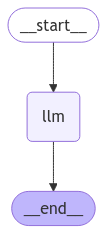

In [8]:
display(Image(supervisor_agent.get_graph().draw_mermaid_png()))

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [9]:
def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    result = supervisor_agent.invoke(state)
    goto = result["messages"][-1].content
    if "FINISH" in goto:
        goto = END
    elif "coder" in goto:
        goto = "coder"
    else:
        # default the route to researcher even if the output does not conform to desired format
        goto = "researcher"

    return Command(goto=goto)

In [10]:
research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. Do not do any calculations or make any charts."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, 
                    # name="researcher"  # this does not work on most of the models
                )
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    # name="coder"
                )
            ]
        },
        goto="supervisor",
    )

In [11]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

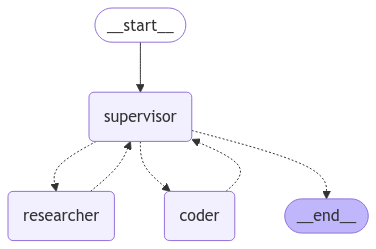

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

(('supervisor:be79361f-8426-384f-f3b4-9c21515a1c2f',), {'llm': {'messages': [AIMessage(content='researcher', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 120, 'total_tokens': 122, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_04751d0b65', 'finish_reason': 'stop', 'logprobs': None}, id='run-59b0ae72-3414-4b89-a5f3-40f804b31d4f-0', usage_metadata={'input_tokens': 120, 'output_tokens': 2, 'total_tokens': 122, 'input_token_details': {}, 'output_token_details': {}})]}})
----
((), {'supervisor': None})
----
(('researcher:70cd824f-25ce-050e-14f2-6b661b2798d2',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qtVEQjfrJPpMFBu4VIvC0OkO', 'function': {'arguments': '{"query":"Hong Kong GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, respons

Python REPL can execute arbitrary code. Use with caution.
Python REPL can execute arbitrary code. Use with caution.


(('coder:d3c3f023-9a69-2892-0989-282b5143e78a',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OYr5YTKKxIQISNtnHdKIQXgo', 'function': {'arguments': '{"code": "# Hong Kong GDP data for the past 5 years (in billion USD)\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_values = [365.0, 343.5, 368.0, 368.5, 380.0]  # Example values\\n\\nimport matplotlib.pyplot as plt\\n\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'Hong Kong GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Billion USD\')\\nplt.xticks(years)\\nplt.grid(True)\\nplt.savefig(\'/mnt/data/hong_kong_gdp_chart.png\')\\nplt.show()"}', 'name': 'python_repl_tool'}, 'type': 'function'}, {'id': 'call_a8yQ0rL4Ojrz9jHygNPoAJr9', 'function': {'arguments': '{"code": "# Hong Kong GDP data for the past 5 years (in billion USD)\\n# This is a placeholder for the actual GDP values\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_value

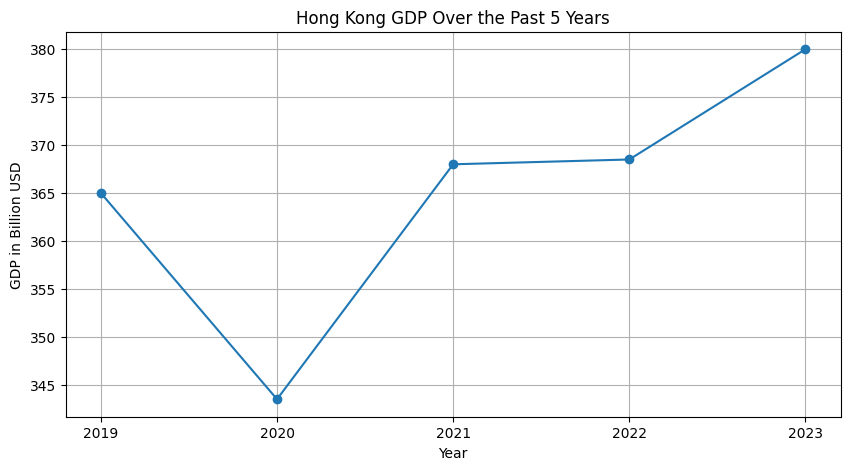

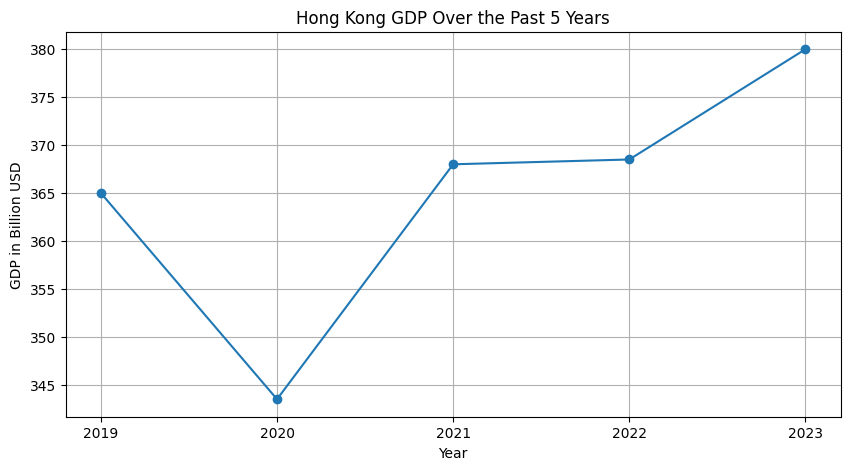

In [13]:
events1 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 30},
    subgraphs=True,
):
    events1.append(s)
    print(s)
    print("----")

In [14]:
for ind, s in enumerate(events1):
    sender = list(s[1].keys())[0]
    if s[1][sender] is None:
        continue
    for message in s[1][sender]["messages"]:
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

================================== Ai Message ==================================

researcher
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_qtVEQjfrJPpMFBu4VIvC0OkO)
 Call ID: call_qtVEQjfrJPpMFBu4VIvC0OkO
  Args:
    query: Hong Kong GDP over the past 5 years
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/statistics/316972/hong-kong-gross-domestic-product/", "content": "Premium Statistic Gross domestic product (GDP) growth in Hong Kong 2001-2028 Premium Statistic GDP share of the financial services industry of Hong Kong 2012-2022 Premium Statistic GDP share of the financial services industry Hong Kong 2012-2022, by category Premium Statistic GDP share of the trading and logistics industry Hong Kong 2012-2022 \"Gross Domestic Product (Gdp) at Current Prices in Hong Kong from 2000 to 2023 with Forecasts un

In [15]:
events2 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of Hong Kong and Singapore, then calculate the geometric average.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 30},
    subgraphs=True,
):
    events2.append(s)
    print(s)
    print("----")

(('supervisor:1dd2c12c-c73e-99c3-0c6b-e01400f174dc',), {'llm': {'messages': [AIMessage(content='researcher', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 95, 'total_tokens': 97, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'tensorrt_llm', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-84974051-a301-457f-a97c-0b3bbe090ca6-0', usage_metadata={'input_tokens': 95, 'output_tokens': 2, 'total_tokens': 97, 'input_token_details': {}, 'output_token_details': {}})]}})
----
((), {'supervisor': None})
----
(('researcher:f385ad0c-2dc8-59e5-d80e-410a6dd64bc8',), {'agent': {'messages': [AIMessage(content='I will search for the latest GDP of Hong Kong and Singapore. I will then calculate the geometric average.', additional_kwargs={'tool_calls': [{'id': 'tavily_search_results_json0', 'function': {'arguments': '{"query":"latest GDP of Hong Kong"}', 'name': 'tavily_sear

Python REPL can execute arbitrary code. Use with caution.


(('coder:1c24dd38-cdb2-3bd1-4ce4-557dc1a81ce3',), {'agent': {'messages': [AIMessage(content='I will calculate the geometric average of the latest GDP of Hong Kong and Singapore.', additional_kwargs={'tool_calls': [{'id': 'python_repl_tool0', 'function': {'arguments': '{"code":"import math\\n\\n# GDP of Hong Kong and Singapore\\nhk_gdp = 382.05\\nsg_gdp = 501.43\\n\\n# Calculate the geometric average\\ngeometric_average = math.sqrt(hk_gdp * sg_gdp)\\nprint(f\\"Geometric average: {geometric_average:.2f} billion\\")"}', 'name': 'python_repl_tool', 'call_id': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 120, 'total_tokens': 235, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'tensorrt_llm', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-88e0ebf6-40b4-4a54-9242-975e656e3f80-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'impo

In [16]:
for ind, s in enumerate(events2):
    sender = list(s[1].keys())[0]
    if s[1][sender] is None:
        continue
    for message in s[1][sender]["messages"]:
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

================================== Ai Message ==================================

researcher
================================== Ai Message ==================================

I will search for the latest GDP of Hong Kong and Singapore. I will then calculate the geometric average.
Tool Calls:
  tavily_search_results_json (tavily_search_results_json0)
 Call ID: tavily_search_results_json0
  Args:
    query: latest GDP of Hong Kong
  tavily_search_results_json (tavily_search_results_json1)
 Call ID: tavily_search_results_json1
  Args:
    query: latest GDP of Singapore
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://tradingeconomics.com/hong-kong/gdp", "content": "The Gross Domestic Product (GDP) in Hong Kong was worth 382.05 billion US dollars in 2023, according to official data from the World Bank. This page provides the latest reported value for - Hong Kong GDP - plus previous releases, historical high